In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import joblib

# Needed for API key
from dotenv import load_dotenv
import os
import requests

In [2]:
stock = 'GME'
load_dotenv()
key = os.getenv('key')

In [3]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={key}'
r = requests.get(url)
data = r.json()

In [4]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GME',
 '3. Last Refreshed': '2025-06-17',
 '4. Output Size': 'Compact',
 '5. Time Zone': 'US/Eastern'}

In [5]:
gme_data = data['Time Series (Daily)']

In [6]:
df = pd.DataFrame.from_dict(gme_data, orient = 'index')
df.index = pd.to_datetime(df.index)
df = df.astype(float)
df = df.sort_index()
df

,1. open,2. high,3. low,4. close,5. volume
2025-01-24,28.30,28.6700,27.6200,27.77,4511646.0
2025-01-27,26.92,27.6796,26.8000,26.97,5060256.0
2025-01-28,27.00,27.5900,26.6539,27.46,3169854.0
2025-01-29,27.41,27.7400,27.0600,27.51,3220404.0
2025-01-30,27.84,28.2300,27.7125,27.99,3343948.0
...,...,...,...,...,...
2025-06-11,29.02,29.4138,28.4200,28.55,18039170.0
2025-06-12,23.57,24.3000,21.5400,22.14,172324520.0
2025-06-13,22.18,23.1500,22.1033,22.14,59849893.0
2025-06-16,22.77,23.4600,22.4100,23.32,31522657.0


In [7]:
# get rid of 1s and 2s in front of column names
df.columns = df.columns.str.replace(r"^\d+\.\s*", "", regex=True)

In [8]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [9]:
df.shape

(100, 5)

In [10]:
df.groupby(df.index.date).size()

2025-01-24    1
2025-01-27    1
2025-01-28    1
2025-01-29    1
2025-01-30    1
             ..
2025-06-11    1
2025-06-12    1
2025-06-13    1
2025-06-16    1
2025-06-17    1
Length: 100, dtype: int64

In [11]:
start_date = df.index.min().date().strftime('%Y%m%d')
end_date = df.index.max().date().strftime('%Y%m%d')

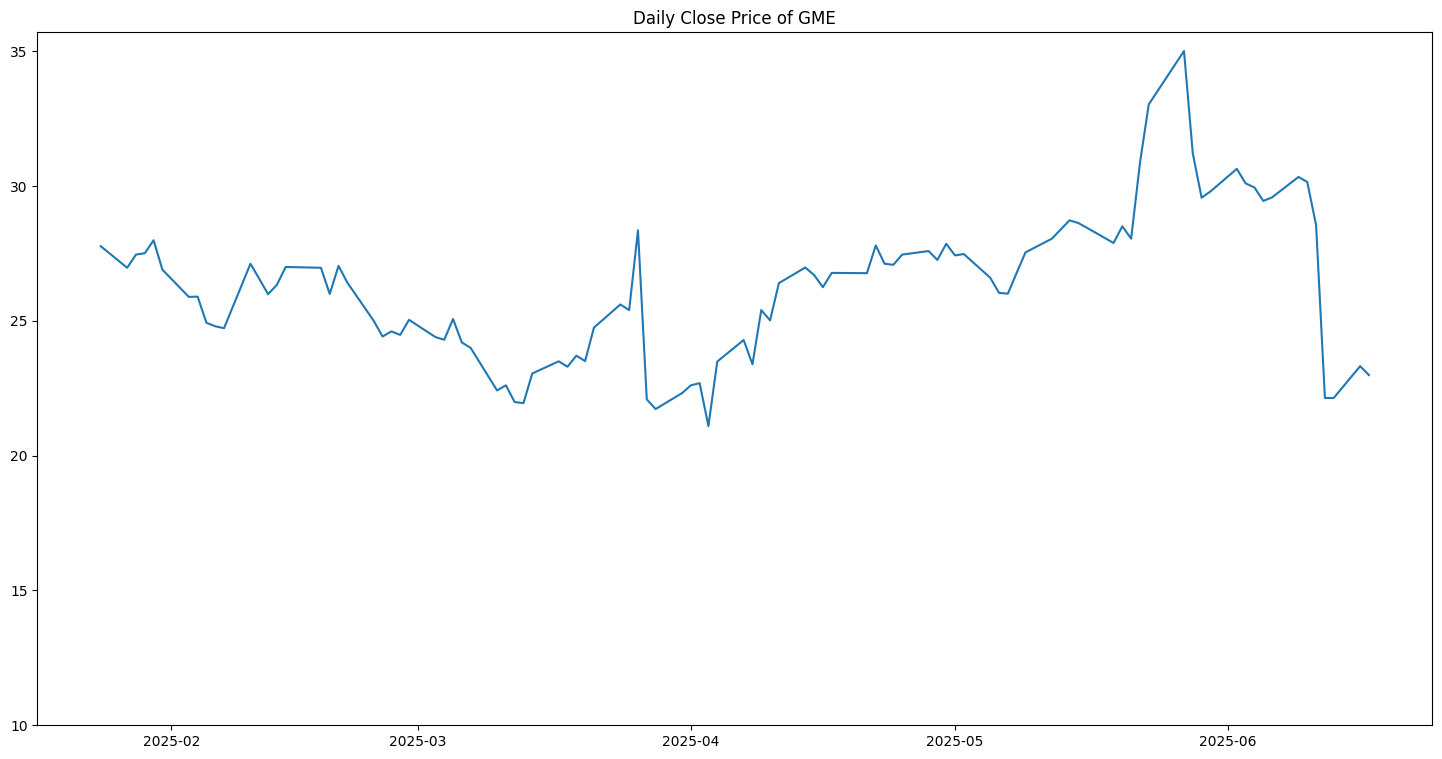

In [12]:
plt.figure(figsize = (18,9))
plt.plot(df['close'])
plt.title('Daily Close Price of GME')
plt.yticks(range(10,40,5));

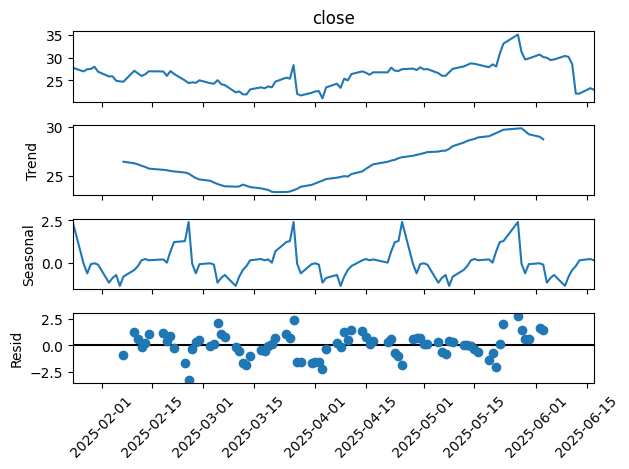

In [13]:
decomp = seasonal_decompose(df['close'],model='additive', period = 21)
fig = decomp.plot()

# Rotate only the Resid x-axis 45 degrees so it is legible
resid_ax = fig.axes[-1]
for label in resid_ax.get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

# Get in News

In [14]:
news_url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={stock}&time_from={start_date}T0000&time_to={end_date}T0000&apikey={key}'
r = requests.get(news_url)
data = r.json()

In [15]:
feed_items = data['feed']

In [16]:
feed_items

[{'title': 'GameStop Corp.  ( GME )  is Attracting Investor Attention: Here is What You Should Know',
  'url': 'https://www.zacks.com/stock/news/2503235/gamestop-corp-gme-is-attracting-investor-attention-here-is-what-you-should-know',
  'time_published': '20250616T130003',
  'authors': ['Zacks Equity Research'],
  'summary': "Zacks.com users have recently been watching GameStop (GME) quite a bit. Thus, it is worth knowing the facts that could determine the stock's prospects.",
  'banner_image': 'https://staticx-tuner.zacks.com/images/default_article_images/default175.jpg',
  'source': 'Zacks Commentary',
  'category_within_source': 'n/a',
  'source_domain': 'www.zacks.com',
  'topics': [{'topic': 'Earnings', 'relevance_score': '0.999999'},
   {'topic': 'Retail & Wholesale', 'relevance_score': '1.0'},
   {'topic': 'Financial Markets', 'relevance_score': '0.54554'}],
  'overall_sentiment_score': 0.259141,
  'overall_sentiment_label': 'Somewhat-Bullish',
  'ticker_sentiment': [{'ticker': 

In [17]:
flat_data = []

for article in feed_items:
    base = {
        'title': article.get('title'),
        'time_published': article.get('time_published'),
        'authors': ", ".join(article.get('authors', [])),
        'summary': article.get('summary'),
        'source': article.get('source'),
        'overall_sentiment_score': article.get('overall_sentiment_score'),
        'overall_sentiment_label': article.get('overall_sentiment_label'),
    }

    # Topics as comma-separated string
    topics = article.get('topics', [])
    topic_names = [t['topic'] for t in topics]
    base['topics'] = ", ".join(topic_names)

    # Ticker sentiment - multiple tickers possible, so one row per ticker
    for ticker_info in article.get('ticker_sentiment', []):
        if ticker_info.get('ticker') == stock:
            base['ticker'] = ticker_info.get('ticker')
            base['ticker_relevance_score'] = ticker_info.get('relevance_score')
            base['ticker_sentiment_score'] = ticker_info.get('ticker_sentiment_score')
            base['ticker_sentiment_label'] = ticker_info.get('ticker_sentiment_label')
            flat_data.append(base)
            break

news = pd.DataFrame(flat_data)

In [18]:
news

,title,time_published,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
0,GameStop Corp. ( GME ) is Attracting Investo...,20250616T130003,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.259141,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.523995,0.168723,Somewhat-Bullish
1,NetEase and Steven Madden have been highlighte...,20250616T122700,Zacks Equity Research,NTES earns Bull of the Day with rising EPS est...,Zacks Commentary,0.207463,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.347165,0.148815,Neutral
2,"This Week in Crypto Games: Dogecoin Got Game, ...",20250615T220102,Andrew Hayward,Dogecoin is about to get a slew of games via D...,Decrypt.co,0.154540,Somewhat-Bullish,"Retail & Wholesale, Blockchain, Financial Markets",GME,0.116348,0.025097,Neutral
3,Can GameStop Stock Rise From the Ashes?,20250615T140000,Geoffrey Seiler,"Under the stewardship of CEO Ryan Cohen, GameS...",Motley Fool,0.071810,Neutral,"Retail & Wholesale, Finance, Financial Markets",GME,0.549581,0.084483,Neutral
4,GameStop Has Taken a Page Out of MicroStrategy...,20250614T130000,Bram Berkowitz,"In 2020, MicroStrategy ( now doing business as...",Motley Fool,0.130934,Neutral,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.715069,0.143994,Neutral
5,"Bulls And Bears: Eli Lilly, Okto, McDonalds - ...",20250614T120017,Benzinga Senior Editor,Benzinga examined the prospects for many inves...,Benzinga,0.162229,Somewhat-Bullish,"Life Sciences, Technology, Economy - Monetary,...",GME,0.115232,-0.046771,Neutral
6,Will GameStop's Bitcoin Swing Be a Home Run or...,20250614T085100,Matt Frankel,Video game retailer GameStop's ( NYSE: GME ) b...,Motley Fool,0.078868,Neutral,"Retail & Wholesale, Financial Markets, Technol...",GME,0.596796,0.091428,Neutral
7,"Public Keys: Circle Keeps Surging, GameStop's ...",20250613T215859,André Beganski,Circle's stock soared again while GameStop sha...,Decrypt.co,0.158955,Somewhat-Bullish,"Life Sciences, Technology, Finance, Blockchain...",GME,0.257328,0.166079,Somewhat-Bullish
8,Bitcoin Treasury Firm GameStop Boosts Converti...,20250613T210913,André Beganski,Shares fell earlier this week after the Texas-...,Decrypt.co,0.192482,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.699089,0.307734,Somewhat-Bullish
9,GameStop Highlights Trading Cards As Next Grow...,20250613T205746,Chris Katje,GameStop is turning to trading cards as its ne...,Benzinga,0.139284,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.643361,0.191591,Somewhat-Bullish


In [19]:
news.isnull().sum()

title                      0
time_published             0
authors                    0
summary                    0
source                     0
overall_sentiment_score    0
overall_sentiment_label    0
topics                     0
ticker                     0
ticker_relevance_score     0
ticker_sentiment_score     0
ticker_sentiment_label     0
dtype: int64

In [20]:
news.shape

(50, 12)

In [21]:
news['authors'].unique()

array(['Zacks Equity Research', 'Andrew Hayward', 'Geoffrey Seiler',
       'Bram Berkowitz', 'Benzinga Senior Editor', 'Matt Frankel',
       'André Beganski', 'Chris Katje', 'Shaun Pruitt',
       'Tirthankar Chakraborty', 'Khyathi Dalal', 'Zoltan Vardai',
       'Ciaran Lyons', 'Sander Lutz', 'Vishaal Sanjay',
       'Murtuza J Merchant', 'Adam Eckert', 'Benzinga Insights',
       'Adam Spatacco', 'Avi Kapoor', '', 'Aniket Verma',
       'Brayden Lindrea', 'Martin Young', 'Mark Vickery',
       'Henry Khederian', 'Stephen Katte', 'Jon Quast', 'Adria Cimino',
       'Marcel Pechman'], dtype=object)

In [22]:
news['time_published'] = news['time_published'].str[:8]
news['time_published'] = pd.to_datetime(news['time_published'], format = '%Y%m%d')
news = news.set_index('time_published')

In [23]:
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-06-16,GameStop Corp. ( GME ) is Attracting Investo...,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.259141,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.523995,0.168723,Somewhat-Bullish
2025-06-16,NetEase and Steven Madden have been highlighte...,Zacks Equity Research,NTES earns Bull of the Day with rising EPS est...,Zacks Commentary,0.207463,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.347165,0.148815,Neutral
2025-06-15,"This Week in Crypto Games: Dogecoin Got Game, ...",Andrew Hayward,Dogecoin is about to get a slew of games via D...,Decrypt.co,0.154540,Somewhat-Bullish,"Retail & Wholesale, Blockchain, Financial Markets",GME,0.116348,0.025097,Neutral
2025-06-15,Can GameStop Stock Rise From the Ashes?,Geoffrey Seiler,"Under the stewardship of CEO Ryan Cohen, GameS...",Motley Fool,0.071810,Neutral,"Retail & Wholesale, Finance, Financial Markets",GME,0.549581,0.084483,Neutral
2025-06-14,GameStop Has Taken a Page Out of MicroStrategy...,Bram Berkowitz,"In 2020, MicroStrategy ( now doing business as...",Motley Fool,0.130934,Neutral,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.715069,0.143994,Neutral
2025-06-14,"Bulls And Bears: Eli Lilly, Okto, McDonalds - ...",Benzinga Senior Editor,Benzinga examined the prospects for many inves...,Benzinga,0.162229,Somewhat-Bullish,"Life Sciences, Technology, Economy - Monetary,...",GME,0.115232,-0.046771,Neutral
2025-06-14,Will GameStop's Bitcoin Swing Be a Home Run or...,Matt Frankel,Video game retailer GameStop's ( NYSE: GME ) b...,Motley Fool,0.078868,Neutral,"Retail & Wholesale, Financial Markets, Technol...",GME,0.596796,0.091428,Neutral
2025-06-13,"Public Keys: Circle Keeps Surging, GameStop's ...",André Beganski,Circle's stock soared again while GameStop sha...,Decrypt.co,0.158955,Somewhat-Bullish,"Life Sciences, Technology, Finance, Blockchain...",GME,0.257328,0.166079,Somewhat-Bullish
2025-06-13,Bitcoin Treasury Firm GameStop Boosts Converti...,André Beganski,Shares fell earlier this week after the Texas-...,Decrypt.co,0.192482,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.699089,0.307734,Somewhat-Bullish


In [24]:
news.groupby(news.index.date).size()

2025-06-05     2
2025-06-06     2
2025-06-07     1
2025-06-08     1
2025-06-09     4
2025-06-10     4
2025-06-11     8
2025-06-12    13
2025-06-13     8
2025-06-14     3
2025-06-15     2
2025-06-16     2
dtype: int64

In [25]:
news[news['authors'] == '']

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-06-12,GameStop shares tank on convertible bond offer...,,The video game retailer announced plans for a ...,CNBC,0.086574,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.434142,0.247095,Somewhat-Bullish
2025-06-11,Nintendo sees record 3.5 million sales of its ...,,Nintendo said it sold over 3.5 million units o...,CNBC,0.224253,Somewhat-Bullish,Retail & Wholesale,GME,0.077593,0.0,Neutral
2025-06-09,Robinhood shares drop after the online brokera...,,Investors were left disappointed after the S&P...,CNBC,0.213438,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Finance...",GME,0.163909,0.053693,Neutral
2025-06-06,Jim Cramer's week ahead: Consumer price index ...,,The 'Mad Money' host walked investors through ...,CNBC,0.208792,Somewhat-Bullish,"Technology, Blockchain, Economy - Monetary, IP...",GME,0.055492,0.035009,Neutral


In [26]:
news.loc[news['authors'] == '', 'authors'] = 'Unknown Author'
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-06-16,GameStop Corp. ( GME ) is Attracting Investo...,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.259141,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.523995,0.168723,Somewhat-Bullish
2025-06-16,NetEase and Steven Madden have been highlighte...,Zacks Equity Research,NTES earns Bull of the Day with rising EPS est...,Zacks Commentary,0.207463,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.347165,0.148815,Neutral
2025-06-15,"This Week in Crypto Games: Dogecoin Got Game, ...",Andrew Hayward,Dogecoin is about to get a slew of games via D...,Decrypt.co,0.154540,Somewhat-Bullish,"Retail & Wholesale, Blockchain, Financial Markets",GME,0.116348,0.025097,Neutral
2025-06-15,Can GameStop Stock Rise From the Ashes?,Geoffrey Seiler,"Under the stewardship of CEO Ryan Cohen, GameS...",Motley Fool,0.071810,Neutral,"Retail & Wholesale, Finance, Financial Markets",GME,0.549581,0.084483,Neutral
2025-06-14,GameStop Has Taken a Page Out of MicroStrategy...,Bram Berkowitz,"In 2020, MicroStrategy ( now doing business as...",Motley Fool,0.130934,Neutral,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.715069,0.143994,Neutral
2025-06-14,"Bulls And Bears: Eli Lilly, Okto, McDonalds - ...",Benzinga Senior Editor,Benzinga examined the prospects for many inves...,Benzinga,0.162229,Somewhat-Bullish,"Life Sciences, Technology, Economy - Monetary,...",GME,0.115232,-0.046771,Neutral
2025-06-14,Will GameStop's Bitcoin Swing Be a Home Run or...,Matt Frankel,Video game retailer GameStop's ( NYSE: GME ) b...,Motley Fool,0.078868,Neutral,"Retail & Wholesale, Financial Markets, Technol...",GME,0.596796,0.091428,Neutral
2025-06-13,"Public Keys: Circle Keeps Surging, GameStop's ...",André Beganski,Circle's stock soared again while GameStop sha...,Decrypt.co,0.158955,Somewhat-Bullish,"Life Sciences, Technology, Finance, Blockchain...",GME,0.257328,0.166079,Somewhat-Bullish
2025-06-13,Bitcoin Treasury Firm GameStop Boosts Converti...,André Beganski,Shares fell earlier this week after the Texas-...,Decrypt.co,0.192482,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.699089,0.307734,Somewhat-Bullish


In [27]:
news['overall_sentiment_label'].unique()

array(['Somewhat-Bullish', 'Neutral', 'Somewhat-Bearish'], dtype=object)

In [28]:
news['ticker_sentiment_label'].unique()

array(['Somewhat-Bullish', 'Neutral', 'Somewhat-Bearish', 'Bullish'],
      dtype=object)

In [29]:
news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})
news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})

C:\Users\graha\AppData\Local\Temp\ipykernel_7756\3453675565.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
C:\Users\graha\AppData\Local\Temp\ipykernel_7756\3453675565.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({


# Merge both DataFrames

In [30]:
merged_df = df.merge(news,how = 'left',left_index = True, right_index = True)
merged_df = merged_df.fillna(0)
merged_df

,open,high,low,close,volume,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2025-01-24,28.30,28.6700,27.6200,27.77,4511646.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2025-01-27,26.92,27.6796,26.8000,26.97,5060256.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2025-01-28,27.00,27.5900,26.6539,27.46,3169854.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2025-01-29,27.41,27.7400,27.0600,27.51,3220404.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2025-01-30,27.84,28.2300,27.7125,27.99,3343948.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-13,22.18,23.1500,22.1033,22.14,59849893.0,GameStop shares tank 22% after boosting raise ...,Zoltan Vardai,GameStop boosts its convertible note offering ...,Cointelegraph,0.040410,3.0,"Retail & Wholesale, Financial Markets, Earning...",GME,0.560201,0.174273,4.0
2025-06-13,22.18,23.1500,22.1033,22.14,59849893.0,Bitcoin slides to $103K as Israel launches air...,Ciaran Lyons,"Jan3 founder Samson Mow tells GameStop CEO, ""T...",Cointelegraph,-0.100327,3.0,"Retail & Wholesale, Financial Markets",GME,0.092213,0.108371,3.0
2025-06-16,22.77,23.4600,22.4100,23.32,31522657.0,GameStop Corp. ( GME ) is Attracting Investo...,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.259141,4.0,"Earnings, Retail & Wholesale, Financial Markets",GME,0.523995,0.168723,4.0
2025-06-16,22.77,23.4600,22.4100,23.32,31522657.0,NetEase and Steven Madden have been highlighte...,Zacks Equity Research,NTES earns Bull of the Day with rising EPS est...,Zacks Commentary,0.207463,4.0,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.347165,0.148815,3.0


In [31]:
merged_df.dtypes

open                       float64
high                       float64
low                        float64
close                      float64
volume                     float64
title                       object
authors                     object
summary                     object
source                      object
overall_sentiment_score    float64
overall_sentiment_label    float64
topics                      object
ticker                      object
ticker_relevance_score      object
ticker_sentiment_score      object
ticker_sentiment_label     float64
dtype: object

In [32]:
merged_df['ticker_relevance_score'] = merged_df['ticker_relevance_score'].astype(float)
merged_df['ticker_sentiment_score'] = merged_df['ticker_sentiment_score'].astype(float)

In [33]:
merged_df = merged_df.drop(columns = ['title','topics','ticker','authors','summary','source'])
merged_df

,open,high,low,close,volume,overall_sentiment_score,overall_sentiment_label,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2025-01-24,28.30,28.6700,27.6200,27.77,4511646.0,0.000000,0.0,0.000000,0.000000,0.0
2025-01-27,26.92,27.6796,26.8000,26.97,5060256.0,0.000000,0.0,0.000000,0.000000,0.0
2025-01-28,27.00,27.5900,26.6539,27.46,3169854.0,0.000000,0.0,0.000000,0.000000,0.0
2025-01-29,27.41,27.7400,27.0600,27.51,3220404.0,0.000000,0.0,0.000000,0.000000,0.0
2025-01-30,27.84,28.2300,27.7125,27.99,3343948.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-06-13,22.18,23.1500,22.1033,22.14,59849893.0,0.040410,3.0,0.560201,0.174273,4.0
2025-06-13,22.18,23.1500,22.1033,22.14,59849893.0,-0.100327,3.0,0.092213,0.108371,3.0
2025-06-16,22.77,23.4600,22.4100,23.32,31522657.0,0.259141,4.0,0.523995,0.168723,4.0
2025-06-16,22.77,23.4600,22.4100,23.32,31522657.0,0.207463,4.0,0.347165,0.148815,3.0


## LSTM Model

In [34]:
# Split off target
features = merged_df.drop(columns=['close'])
target = merged_df[['close']]

# Normalize
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target)

# Reassemble DataFrame
scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
scaled_df['close'] = target_scaled

In [35]:
def create_lstm_dataset(data, target_column, look_back):
    """
    Convert a dataframe into LSTM-compatible 3D sequences for a specific target column.
    
    Parameters:
    - data: pandas DataFrame (rows = time, cols = features)
    - target_column: name of the column to predict (e.g., 'Close')
    - look_back: number of past time steps to include

    Returns:
    - X: shape (num_samples, look_back, num_features)
    - y: shape (num_samples,)
    """
    # Extract features and target column
    features = data.drop(columns=[target_column]).values  # All columns except target
    target = data[target_column].values  # Target column
    
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(features[i:i+look_back])  # Look-back window of features
        y.append(target[i + look_back])  # Next time-step's target value
        
    return np.array(X), np.array(y)
look_back = 10
X_all, y_all = create_lstm_dataset(scaled_df, target_column='close', look_back=look_back)

# Use all data except the final 14 days (7 for evaluation + 7 for prediction)
test_days = 7
eval_days = 7
X_train = X_all[:- (test_days + eval_days)]
y_train = y_all[:- (test_days + eval_days)]

X_eval = X_all[-(test_days + eval_days):-test_days]
y_eval = y_all[-(test_days + eval_days):-test_days]

In [36]:
# Define the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

C:\Users\graha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
early_stop = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,          # Stop after 10 epochs with no improvement
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # Needed for val_loss monitoring
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.1102 - val_loss: 0.2358
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0367 - val_loss: 0.0373
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0333 - val_loss: 0.0408
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0159 - val_loss: 0.0579
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0193 - val_loss: 0.0366
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0146 - val_loss: 0.0452
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0185 - val_loss: 0.0741
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0171 - val_loss: 0.0563
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0154 - val_loss: 0.0636
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0154 - val_loss: 0.0933
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0168 - val_loss: 0.0649
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0135 - val_l

In [38]:
y_eval_pred = model.predict(X_eval)
y_eval_pred_unscaled = target_scaler.inverse_transform(y_eval_pred)
y_eval_actual_unscaled = target_scaler.inverse_transform(y_eval.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


In [39]:
last_window = scaled_df.drop(columns=['close']).values[-look_back:]

future_predictions_scaled = []
input_seq = last_window.copy()

for _ in range(7):  # Predict 7 days
    pred = model.predict(input_seq[np.newaxis, :, :])[0, 0]
    future_predictions_scaled.append(pred)

    # Append the prediction to the feature window (use previous features and predicted close)
    next_features = np.append(input_seq[-1, :-1], pred)  # Replace last 'close'
    input_seq = np.vstack([input_seq[1:], next_features])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [40]:
# Unscale predictions
future_preds_unscaled = target_scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

In [41]:
# Get the last available date in your dataset
last_known_date = merged_df.index[-1]

# Generate next 7 business days after last known stock price date
future_dates = pd.bdate_range(start=last_known_date + pd.Timedelta(days=1), periods=7)

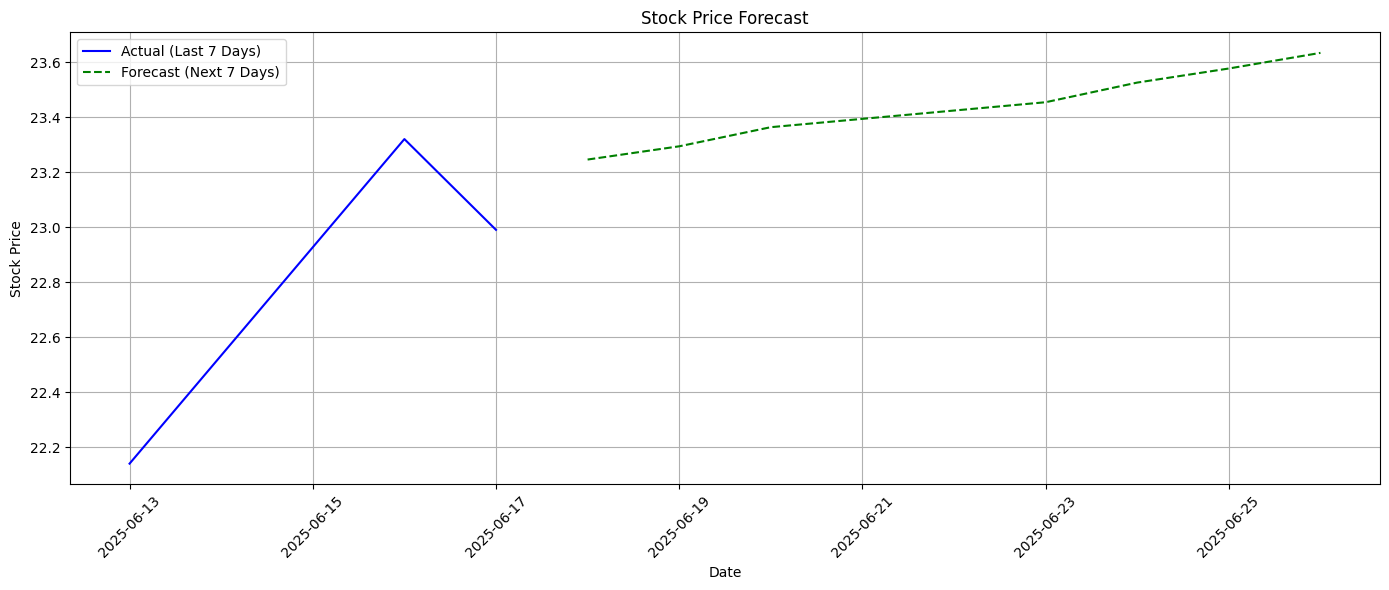

In [42]:
plt.figure(figsize=(14, 6))

# Plot actual stock prices for the last N days (e.g., last 7)
plt.plot(merged_df.index[-7:], merged_df['close'].values[-7:], label="Actual (Last 7 Days)", color="blue")

# Plot predicted prices for the next 7 business days
plt.plot(future_dates, future_preds_unscaled, label="Forecast (Next 7 Days)", color="green", linestyle='--')

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Forecast")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Random Forest Model 7 day

In [43]:
df= merged_df.copy()

df['target'] = df['close'].shift(-7)
df = df.dropna()

X = df.drop(columns=['target'])
y = df['target']

In [44]:
pipe = Pipeline([
    ('scaler', StandardScaler()),     
    ('rf',     RandomForestRegressor(random_state=42))
])

In [45]:
tscv = TimeSeriesSplit(n_splits=5)

In [46]:
param_dist = {
    'rf__n_estimators':      np.arange(100, 1000),
    'rf__max_depth':         [None] + list(np.arange(5, 51)),
    'rf__min_samples_split': np.arange(2,51),
    'rf__min_samples_leaf':  np.arange(1,11)
}

random_search = RandomizedSearchCV(
    estimator = pipe,
    param_distributions = param_dist,
    n_iter = 300,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    verbose = 2,
    n_jobs = -1,
    random_state = 42
)

random_search.fit(X, y)

print("Best RMSE (random search):", -random_search.best_score_)
print("Best params (random search):", random_search.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best RMSE (random search): 2.9753082730224603
Best params (random search): {'rf__n_estimators': 576, 'rf__min_samples_split': 26, 'rf__min_samples_leaf': 10, 'rf__max_depth': 32}


In [47]:
best_params = random_search.best_params_

param_grid = {
    'rf__n_estimators': [best_params['rf__n_estimators'] - 100,
                         best_params['rf__n_estimators'],
                         best_params['rf__n_estimators'] + 100],
    'rf__max_depth': [best_params['rf__max_depth'] - 5 if best_params['rf__max_depth'] else None,
                      best_params['rf__max_depth'],
                      best_params['rf__max_depth'] + 5 if best_params['rf__max_depth'] else None],
    'rf__min_samples_split': [best_params['rf__min_samples_split']],
    'rf__min_samples_leaf':  [best_params['rf__min_samples_leaf']]
}

# Clean None-related values
param_grid['rf__max_depth'] = [x for x in param_grid['rf__max_depth'] if x is not None]

grid_search = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    verbose = 2,
    n_jobs = -1
)

grid_search.fit(X, y)

print("Best RMSE (grid search):", -grid_search.best_score_)
print("Best params (grid search):", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best RMSE (grid search): 2.968426034208296
Best params (grid search): {'rf__max_depth': 27, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 26, 'rf__n_estimators': 476}


In [48]:
y_pred = grid_search.predict(X)
pred_series = pd.Series(y_pred, index=X.index)

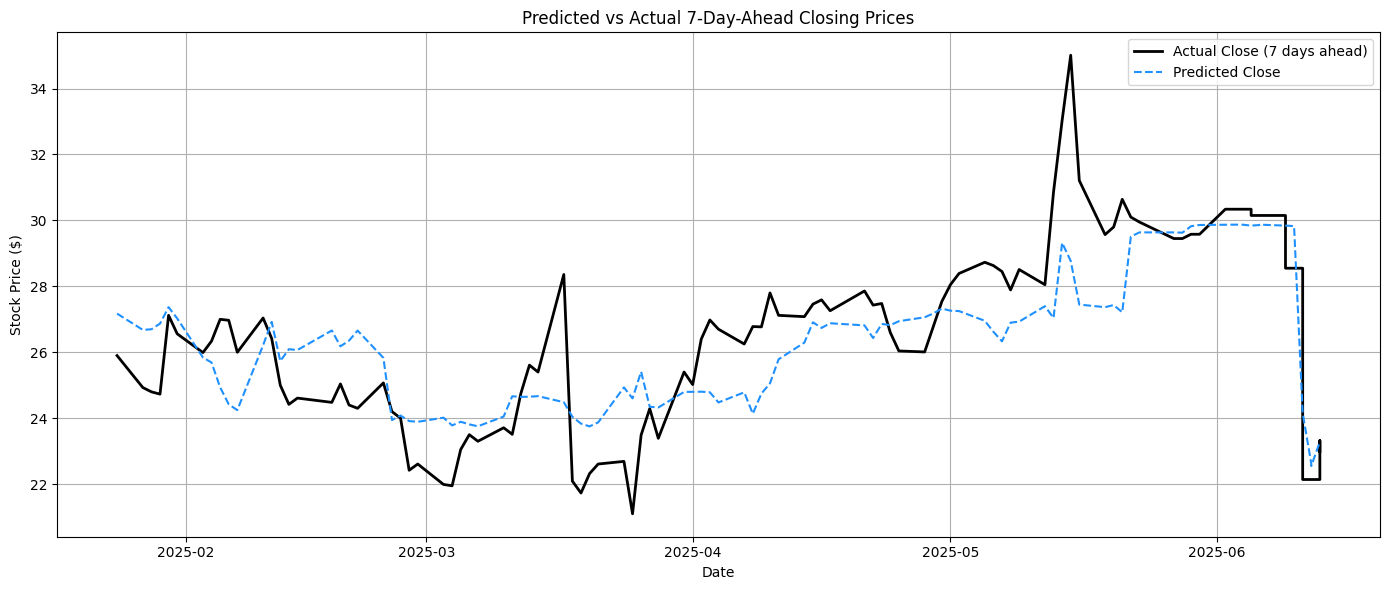

In [49]:
plt.figure(figsize=(14, 6))
plt.plot(y.index, y, label='Actual Close (7 days ahead)', color='black', linewidth=2)
plt.plot(pred_series.index, pred_series, label='Predicted Close', color='dodgerblue', linestyle='--')
plt.title('Predicted vs Actual 7-Day-Ahead Closing Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
joblib.dump(random_search.best_estimator_, "models/best_rf_model_3.pkl")

['models/best_rf_model_3.pkl']

# Random Forest Model 1 Day

In [51]:
df= merged_df.copy()

df['target'] = df['close'].shift(-1)
df = df.dropna()

X = df.drop(columns=['target'])

In [52]:
y = df['target']

pipe = Pipeline([
    ('scaler', StandardScaler()),     
    ('rf',     RandomForestRegressor(random_state=42))
])

In [53]:
tscv = TimeSeriesSplit(n_splits=5)

In [54]:
param_dist = {
    'rf__n_estimators':      np.arange(100, 1000),
    'rf__max_depth':         [None] + list(np.arange(5, 51)),
    'rf__min_samples_split': np.arange(2,51),
    'rf__min_samples_leaf':  np.arange(1,11)
}

random_search = RandomizedSearchCV(
    estimator = pipe,
    param_distributions = param_dist,
    n_iter = 300,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    verbose = 2,
    n_jobs = -1,
    random_state = 42
)

random_search.fit(X, y)

print("Best RMSE (random search):", -random_search.best_score_)
print("Best params (random search):", random_search.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best RMSE (random search): 1.8069688279224994
Best params (random search): {'rf__n_estimators': 683, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 4, 'rf__max_depth': 14}


In [55]:
best_params = random_search.best_params_

param_grid = {
    'rf__n_estimators': [best_params['rf__n_estimators'] - 100,
                         best_params['rf__n_estimators'],
                         best_params['rf__n_estimators'] + 100],
    'rf__max_depth': [best_params['rf__max_depth'] - 5 if best_params['rf__max_depth'] else None,
                      best_params['rf__max_depth'],
                      best_params['rf__max_depth'] + 5 if best_params['rf__max_depth'] else None],
    'rf__min_samples_split': [best_params['rf__min_samples_split']],
    'rf__min_samples_leaf':  [best_params['rf__min_samples_leaf']]
}

# Clean None-related values
param_grid['rf__max_depth'] = [x for x in param_grid['rf__max_depth'] if x is not None]

grid_search = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    verbose = 2,
    n_jobs = -1
)

grid_search.fit(X, y)

print("Best RMSE (grid search):", -grid_search.best_score_)
print("Best params (grid search):", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best RMSE (grid search): 1.8069688279224994
Best params (grid search): {'rf__max_depth': 9, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 5, 'rf__n_estimators': 683}


In [56]:
y_pred = grid_search.predict(X)
pred_series = pd.Series(y_pred, index=X.index)

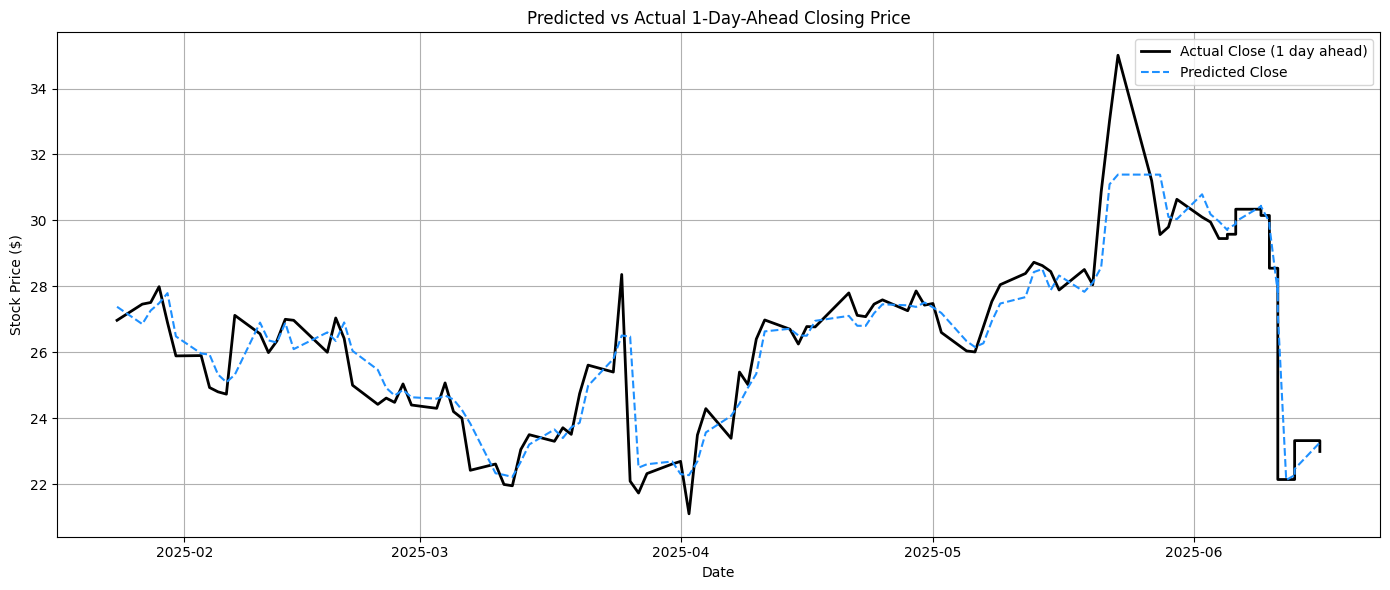

In [57]:
plt.figure(figsize=(14, 6))
plt.plot(y.index, y, label='Actual Close (1 day ahead)', color='black', linewidth=2)
plt.plot(pred_series.index, pred_series, label='Predicted Close', color='dodgerblue', linestyle='--')
plt.title('Predicted vs Actual 1-Day-Ahead Closing Price')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
joblib.dump(random_search.best_estimator_, "models/best_rf_model-1-day_2.pkl")

['models/best_rf_model-1-day_2.pkl']